In [1]:
import sys, os
sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'analysis'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', 'session'))
sys.path.append(os.path.join(os.getcwd(), '..', '..', '..', 'pplSIT', 'workflow', 'utils'))

from imports import *
from loading import load_session_data
import numpy as np
import h5py, json
import matplotlib.pyplot as plt
from scipy import signal, stats
from target import build_tgt_matrix
from adapters import DatProcessor
from matplotlib.patches import ConnectionPatch
from mpl_toolkits.axes_grid1 import make_axes_locatable
from session.sessions import selected_009266, selected_008229, selected_009265
from target import build_tgt_matrix, get_spike_counts, build_silence_and_noise_events, \
        get_idxs_of_event_periods, get_spike_times_at
np.set_printoptions(suppress=True)

from population import unit_response_matrix, activity_at_phase

%matplotlib inline

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
source = '/home/sobolev/nevermind/AG_Pecka/data/processed/'
rep_path = '/home/sobolev/nevermind/Andrey/analysis/manuscripts/'

#sessions = [s for s in selected_008229.keys()]
sessions = [s for s in selected_009266.keys()]
#sessions = [s for s in selected_009265.keys()]
sessions.sort()
sessions

['009266_hippoSIT_2023-04-17_17-04-17',
 '009266_hippoSIT_2023-04-18_10-10-37',
 '009266_hippoSIT_2023-04-18_17-03-10',
 '009266_hippoSIT_2023-04-19_10-33-51',
 '009266_hippoSIT_2023-04-20_08-57-39',
 '009266_hippoSIT_2023-04-21_08-43-00',
 '009266_hippoSIT_2023-04-21_13-12-31',
 '009266_hippoSIT_2023-04-24_10-08-11',
 '009266_hippoSIT_2023-04-24_16-56-55',
 '009266_hippoSIT_2023-04-26_08-20-17',
 '009266_hippoSIT_2023-05-02_12-22-14',
 '009266_hippoSIT_2023-05-04_19-47-15',
 '009266_hippoSIT_2023-05-22_09-27-22',
 '009266_hippoSIT_2023-05-23_09-18-05',
 '009266_hippoSIT_2023-05-25_15-55-57',
 '009266_hippoSIT_2023-06-14_08-21-23',
 '009266_hippoSIT_2023-06-19_08-58-35']

## Experiment timeline plot

In [36]:
session = sessions[0]
session

'009266_hippoSIT_2023-04-17_17-04-17'

In [37]:
animal     = session.split('_')[0]
s_path     = os.path.join(source, animal, session)
meta_file  = os.path.join(source, animal, session, 'meta.h5')
moseq_file = os.path.join(source, animal, session, 'MoSeq.h5')
syll_file  = os.path.join(source, animal, session, 'analysis', 'MoSeq_tSNE_UMAP.h5')

with h5py.File(meta_file, 'r') as f:
    tl = np.array(f['processed']['timeline'])
    tgt_mx = np.array(f['processed']['target_matrix'])
    events = np.array(f['processed']['sound_events'])
with h5py.File(moseq_file, 'r') as f:
    moseq = np.array(f['moseq'])
    headers = f['moseq'].attrs['headers']
with h5py.File(syll_file, 'r') as f:
    syl_ratio_mx = np.array(f['syl_ratio_mx'])
    idxs_srm_tl  = np.array(f['idxs_srm_tl'])
    
p_sil = tl[events[events[:, 1] == 0][:, 2].astype(np.int32)][:, 0]
p_noi = tl[events[events[:, 1] ==-1][:, 2].astype(np.int32)][:, 0]
p_bgr = tl[events[events[:, 1] == 1][:, 2].astype(np.int32)][:, 0]
p_tgt = tl[events[events[:, 1] == 2][:, 2].astype(np.int32)][:, 0]

array([  58.76,  110.27,  151.02,  210.77,  346.02,  504.03,  701.53,
        761.78,  839.78,  889.29, 1108.54, 1230.04, 1263.04, 1299.79,
       1366.3 , 1396.3 , 1532.3 , 1672.05, 1795.06, 2027.56, 2066.06,
       2214.57, 2258.82, 2289.32, 2366.82])

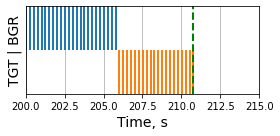

In [34]:
#fig, ax = plt.subplots(1, 1, figsize=(6, 4))  # with MoSeq
fig, ax = plt.subplots(1, 1, figsize=(4, 2))  # without MoSeq

colors = list(reversed(plt.rcParams['axes.prop_cycle'].by_key()['color']))
#x_l, x_r = 0, 300
#x_l, x_r = 0, 200
x_l, x_r = 200, 215
#x_l, x_r = 0, 15

# plot individual syllables
# for i in range(10):
#     x_vals = np.where(moseq[:, 1] == i)[0]/100.
#     x_vals = x_vals[ (x_vals > x_l) & (x_vals < x_r) ]
#     ax.vlines(x_vals, 2+i/5, 2+i/5+0.2, lw=1, color=colors[i])

# plot syllable ratios
# step = 0.25
# idxs_to_idxs = np.where((tl[idxs_srm_tl][:, 0] > x_l) & (tl[idxs_srm_tl][:, 0] < x_r))[0]
# idxs_sel = idxs_srm_tl[idxs_to_idxs]
# bottom = np.zeros(len(idxs_sel)) + 2
# for i, syl_ratio in enumerate(2*syl_ratio_mx[idxs_to_idxs].T):
#     ax.bar(tl[idxs_sel][:, 0] + step, syl_ratio, 0.7, bottom=bottom, label='Syll. # %s' % str(i+1), color=colors[i])
#     bottom += syl_ratio

# plot stimulations
ax.vlines(p_bgr, 1, 2, color='tab:blue', lw=2)  # BGR
ax.vlines(p_tgt, 0, 1, color='tab:orange', lw=2) # TGT 
#ax.vlines(p_noi,-1, 0, color='red', lw=1)  # NOI
#ax.vlines(p_sil, 0, 1, color='black', lw=1, alpha=0.99)#, ls='--')

# plot success targets
t_success = tl[tgt_mx[tgt_mx[:, 4] == 1][:, 3].astype(np.int32)][:, 0]
ax.vlines(t_success, 0, 2, color='green', lw=2, ls='--')

ax.set_xlim(x_l, x_r)
#ax.set_ylim(0, 4)  # set to 0-4 for MoSeq
ax.set_ylim(0, 2)  # set to 0-2 for just TGT / BGR
ax.set_xlabel("Time, s", fontsize=14)
#ax.set_ylabel("Noise | BGR | TGT | Syllable", fontsize=14)
#ax.set_ylabel("BGR | TGT | Behavior", fontsize=14)
ax.set_ylabel("TGT | BGR", fontsize=14)
ax.grid()
ax.set_yticks([])


fig.tight_layout()

In [35]:
#fig.savefig(os.path.join(rep_path, '%s_timeline_with_MoSeq.png' % session[-19:-6]), dpi=300)
fig.savefig(os.path.join(rep_path, '%s_timeline_%d_%d.png' % (session[-19:-6], x_l, x_r)), dpi=300)

In [16]:
animal = session.split('_')[0]
s_path = os.path.join(source, animal, session)

# Population activity
w_mx = []
for phase in [1, 2, 3, 4]:
    w_pca = activity_at_phase(s_path, phase, do_pca=True)
    w_mx.append(w_pca) # stay in events space
w_mx = np.column_stack(w_mx)

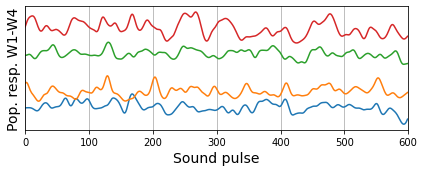

In [19]:
fig, ax = plt.subplots(1, 1, figsize=(6, 2.5))

x_l, x_r = 0, 600
ax.plot(w_mx[:, 0][x_l:x_r])
ax.plot(w_mx[:, 1][x_l:x_r] + 2)
ax.plot(w_mx[:, 2][x_l:x_r] + 4)
ax.plot(w_mx[:, 3][x_l:x_r] + 6)
ax.set_xlim(x_l, x_r)
ax.grid()
ax.set_yticks([])
ax.set_xlabel('Sound pulse', fontsize=14)
ax.set_ylabel('Pop. resp. W1-W4', fontsize=14)
fig.tight_layout()

In [20]:
fig.savefig(os.path.join(report, 'showroom', 'pop_resp_W1_W4_mid.png'), dpi=500)